# Carregando o Dataset

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import math
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
database = pd.read_csv("train_data.csv")
database = database[["timestamp", "d_rho_vv", "d_mean", "DESC"]]
database.head(5)

,timestamp,d_rho_vv,d_mean,DESC
0,2019-12-03 07:40:33,-0.746080,-0.004370,1
1,2019-12-03 07:40:34,-0.758935,-0.004015,1
2,2019-12-03 07:40:35,-0.751754,-0.003663,1
3,2019-12-03 07:40:36,-0.753073,-0.003310,1
4,2019-12-03 07:40:37,-0.758822,-0.002957,1


In [3]:
database.shape


(15020, 4)

In [4]:
X = database.drop("timestamp", axis=1)
X = X.drop("DESC", axis=1)
y = database["DESC"]
print("X shape: " + str(X.shape))
print("y shape: " + str(y.shape))
X = X.to_numpy()
y = y.to_numpy()

X shape: (15020, 2)
y shape: (15020,)


# Visualização dos Dados

In [5]:
X1 = database[database["DESC"]==0].to_numpy()
X2 = database[database["DESC"]==1].to_numpy()

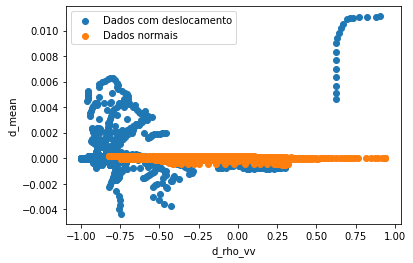

In [6]:
plt.figure()
labels = ["Dados com deslocamento", "Dados normais"]
plt.scatter(X2[:,1], X2[:,2], label = labels[0])
plt.scatter(X1[:,1], X1[:,2], label = labels[1])
plt.legend()
plt.xlabel("d_rho_vv")
plt.ylabel("d_mean")
plt.show()

# Aplicação do modelo SVM e busca por parâmetro C mais adequado

In [7]:
parameters = {'C':range(1, 30)}
svc = svm.SVC(kernel="rbf")
clf = GridSearchCV(svc, parameters, scoring='accuracy', refit=True, cv=10)  #To see results for each C just add: verbose=3
# Run fit with all sets of parameters.
clf.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None, param_grid={'C': range(1, 30)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [8]:
C = clf.best_params_
score = clf.best_score_
print("The best accuracy average was " + str(score) + " and was achieved for " + str(C) )

The best accuracy average was 0.913249001331558 and was achieved for {'C': 2}


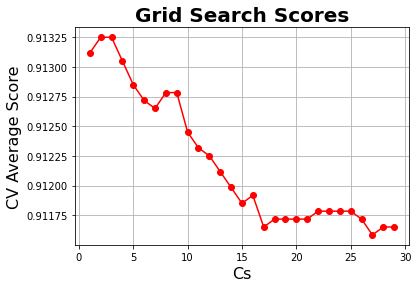

In [9]:
def plot_grid_search(cv_results, grid_param_1, name_param_1):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean)

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd)

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    ax.plot(grid_param_1, scores_mean[:], '-o', color="red")

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')

# Calling Method 
Cs = np.arange(1,30)
plot_grid_search(clf.cv_results_, Cs, 'Cs')

# Avaliação do Modelo

In [10]:
acc = np.zeros(10)
for i in range(0, 10):
    # Separate data between training and test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Training:
    clf = make_pipeline(StandardScaler(), svm.SVC(kernel="rbf", C=6))
    clf.fit(X_train, y_train)

    # Call predict on the estimator with the best found parameters.
    y_pred = clf.predict(X_test)
    acc[i] = (accuracy_score(y_test,y_pred))
    
print("A acurácia média e desvio padrão para 10 experimentos foi:")
print('{:.3f}'.format(acc.mean()) + " +/- " + '{:.3f}'.format(acc.std()))



A acurácia média e desvio padrão para 10 experimentos foi:
0.940 +/- 0.002



Acc: 0.9400798934753661


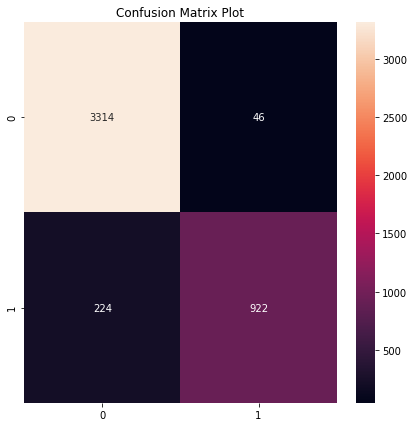

In [11]:
n_features = 2
df_confusion = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7,7))         # Sample figsize in inches
sns.heatmap(df_confusion, annot=True, ax=ax, fmt='g')
plt.title('Confusion Matrix Plot')
    
#plot_confusion_matrix(df_confusion)
print("\nAcc: " + str(accuracy_score(y_test,y_pred)))


# Borda de Decisão

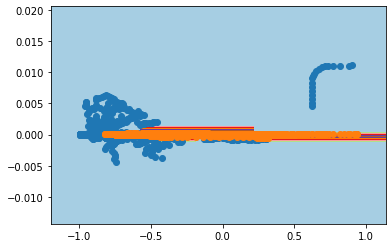

In [14]:
def plot_decision_border(X, y, clf):
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-0.2, X[:, 0].max()+0.2
    min2, max2 = X[:, 1].min()-0.01, X[:, 1].max()+0.01
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.001)
    x2grid = np.arange(min2, max2, 0.001)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = clf.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired_r')
    # create scatter plot for samples from each class
    for class_value in [1,0]:
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    # show the plot
    plt.show()

    
plot_decision_border(X, y, clf)



# Curva ROC

accuracy is 0.940


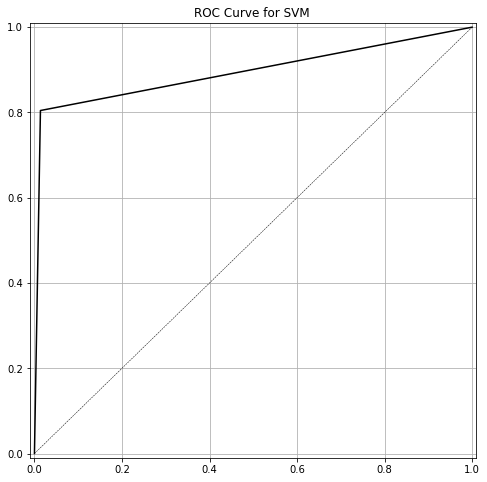

In [19]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} '.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred)))

plot_roc(y_test, y_pred, 'SVM')